# Тестирование обученной сети на реальных фотографиях окурков 

In [1]:
import os
import numpy as np

from glob import glob
from PIL import Image
from datetime import datetime


def generate_html(path_to_data):
    """Generates content of html file and saves it.
    Parameters
    ----------
    path_to_data : str
        Path to data with original images, predicted masks, and cropped according masks images.
    Returns
    -------
    str
        Content of html file.
    """
    html = "\n".join(["<!doctype html>", "<html>", "<head>",
                      "<meta http-equiv='Content-Type' content='text/html; charset=utf-8'>",
                      "<title>Визуализация результатов</title>", "</head>", "<body>",
                      "<table cellspacing='0' cellpadding='5'>"]) + "\n"
    paths_to_imgs = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_img.jpg")])
    paths_to_masks = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_pred_mask.png")])
    paths_to_crops = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_crop.png")])
    for ind, (path_to_img, path_to_mask, path_to_crop) in enumerate(zip(paths_to_imgs,
                                                                        paths_to_masks,
                                                                        paths_to_crops)):
        if not ind % 2:
            html += "<tr>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_img}'"
        html += "alt='Something went wrong.'"
        html += f"height='320' title='Original image:\n{path_to_img}'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_mask}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Predicted mask'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_crop}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Cropped img according\npredicted mask'></td>\n"
        if not ind % 2:
            html += "<td width='100'></td>\n"
        else:
            html += "</tr>\n"
    date = datetime.today().strftime("%Y-%m-%d-%H.%M.%S")
    html += f"</table>\n<i>The page was generated at {date}</i></body>\n</html>"
    filename = os.path.basename(path_to_data) + ".html"
    path_to_save = os.path.dirname(path_to_data)
    with open(f"{path_to_save}/{filename}", "w") as f:
        f.write(html)

    return html


def get_html(paths_to_imgs, pred_masks, path_to_save="results/test"):
    """Generates html file and saves it.
    Parameters
    ----------
    paths_to_imgs : list[str]
        List of paths to original images.
    pred_masks : list[np.ndarray]
        Predicted masks.
    path_to_save : str
        Path to save source images to put them in html file. Html name is the same as name of the
        last folder on `path_to_save` and is saved on upper level.
    Returns
    -------
    str
        Content of html file.
    """
    paths_to_imgs = np.array(paths_to_imgs)
    pred_masks = np.array(pred_masks)

    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    order = np.argsort(paths_to_imgs)
    paths_to_imgs = paths_to_imgs[order]
    pred_masks = pred_masks[order]

    for path_to_img, pred_mask in zip(paths_to_imgs, pred_masks):
        img_id = path_to_img.split("/")[-1].split(".")[0]
        img = np.array(Image.open(path_to_img))[:, :, :3]
        Image.fromarray(img).save(f"{path_to_save}/{img_id}_img.jpg")
        Image.fromarray(pred_mask).save(f"{path_to_save}/{img_id}_pred_mask.png")
        crop_img = img.copy()
        crop_img[pred_mask == 0] = 0
        Image.fromarray(crop_img).save(f"{path_to_save}/{img_id}_crop.png")

    html = generate_html(path_to_save)

    return html

### Будем пользоваться уже обученными нашей моделью весами, которые мы сохранили из ноутбука Cigarette_butt_segmentation.ipynb 

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
   

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [3]:
# У нас всего два класса, это окурок и фон 
num_classes = 2

# Получим экземпляр нашей модели с предобученными весами 
model = get_instance_segmentation_model(num_classes)

In [4]:
PATH = './new/weights.pth'

In [5]:
import torch
# загрузим сохраненные веса модели и не забудем перейти в eval режим 

model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

In [6]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 8.0)

In [7]:
!git clone https://github.com/RostislavKorst/cigarette_butt_segmentation.git && pip install -r cigarette_butt_segmentation/requirements.txt
import sys; sys.path.append('./cigarette_butt_segmentation')

"git" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


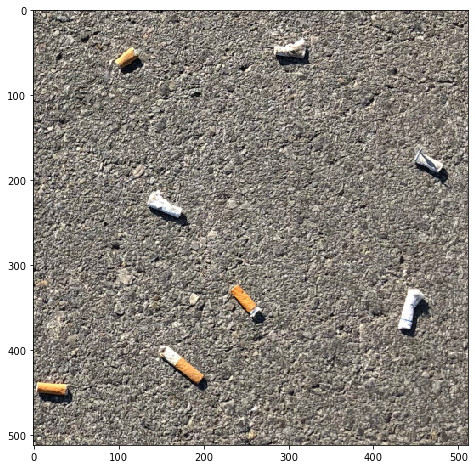

In [8]:
path_to_test = './new/Cigs/0004.JPG'

img = Image.open(path_to_test)
plt.imshow(img) 

In [9]:
import torchvision.transforms as transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.eval()
with torch.no_grad():
    trans1 = transforms.ToTensor()
    img_tensor = trans1(img)
    prediction = model([img_tensor.to(device)])

In [11]:
import numpy as np
path = './new/Cigs2/000'
jpg = '.JPG'
paths_to_imgs = [path + str(i) + jpg for i in range(10)]
paths_to_imgs

['./new/Cigs2/0000.JPG',
 './new/Cigs2/0001.JPG',
 './new/Cigs2/0002.JPG',
 './new/Cigs2/0003.JPG',
 './new/Cigs2/0004.JPG',
 './new/Cigs2/0005.JPG',
 './new/Cigs2/0006.JPG',
 './new/Cigs2/0007.JPG',
 './new/Cigs2/0008.JPG',
 './new/Cigs2/0009.JPG']

In [15]:
# Функция, которая из листа масок делает одну маску 
def listmasks2mask(maskslist):
    """
    params:
    maskslist - list of masks - list(ndarray)

    returns:
    mask - one mask with many masks on in - ndarray
    """
    print(len(maskslist))
    mask = np.zeros((512, 512)).astype(np.uint8)

    for mask_cur in maskslist:

        a = mask_cur
        a = a*10**8
        a = np.where(a > 2., a, 0).astype(np.int64)
        a = np.where(a < 40000000, 0, 255).astype(np.uint8)
        a = np.where(a == 0, a, 255)
        mask_cur = a
        tuple_of_indexes = np.nonzero(mask_cur)
        #for i, j in zip(tuple_of_indexes[0], tuple_of_indexes[0]):
            #mask[i][j] = mask_cur[i][j]
        mask[tuple_of_indexes] = mask_cur[tuple_of_indexes]

    return mask

9


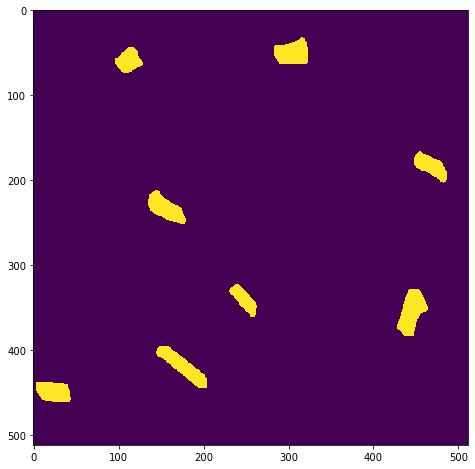

In [16]:
# list(prediction[0]['masks'].cpu().numpy().reshape(1, 9, 512, 512)[0])

plt.imshow(listmasks2mask(list(prediction[0]['masks'].cpu().numpy().reshape(1, prediction[0]['masks'].cpu().numpy().shape[0], 512, 512)[0])))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

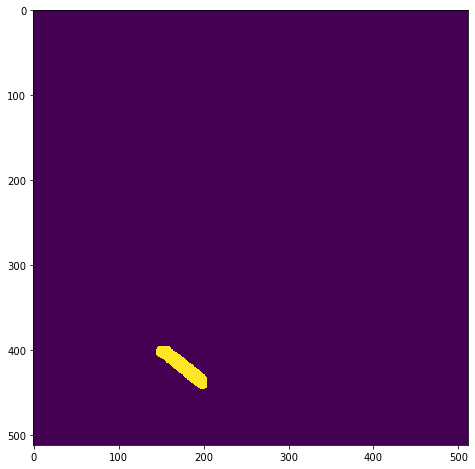

In [17]:
a = prediction[0]['masks'].cpu().numpy()[0][0]
#plt.imshow(a)
#plt.imshow((a*10**15).astype(np.uint8))
a = a*10**8
a = np.where(a > 2., a, 0).astype(np.int64)
a = np.where(a < 30000000, 0, 255)
plt.imshow(a)
a

In [19]:
pred_masks = list()

for path_to_test in paths_to_imgs:
    img = Image.open(path_to_test)
    model.eval()
    with torch.no_grad():
        trans1 = transforms.ToTensor()
        img_tensor = trans1(img)
        prediction = model([img_tensor.to(device)])
        a = listmasks2mask(list(prediction[0]['masks'].cpu().numpy().reshape(1, prediction[0]['masks'].cpu().numpy().shape[0], 512, 512)[0]))
        pred_masks.append(a)

2
2
1
1
9
3
8
2
1
9


In [20]:
_ = get_html(paths_to_imgs, pred_masks, path_to_save='C:\\python\\Cigs1\\')